In [1]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import matplotlib.animation as animation
import types
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import matplotlib.patches as patches
% matplotlib inline

In [5]:
nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/Y*2008*.nc'))#*_ptrc_T*.nc'))
print("found *.nc file: \n{}".format(nc_filename))
ptrc=nc.Dataset(nc_filename[0])

uvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG4_gridU_20072009.nc')
print uvel.variables

vvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG4_gridV_20072009.nc')
print vvel.variables

wvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG4_gridW_20072009.nc')
print wvel.variables

found *.nc file: 
['/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/Y19682008.nc']
OrderedDict([(u'nav_lon', <netCDF4.Variable object at 0x7fa06989ba68>), (u'nav_lat', <netCDF4.Variable object at 0x7fa06989bb00>), (u'depthu', <netCDF4.Variable object at 0x7fa06989bd60>), (u'time_counter', <netCDF4.Variable object at 0x7fa06989bdf8>), (u'vozocrtx', <netCDF4.Variable object at 0x7fa06989bc30>), (u'sozotaux', <netCDF4.Variable object at 0x7fa06989bcc8>)])
OrderedDict([(u'nav_lon', <netCDF4.Variable object at 0x7fa0698b2770>), (u'nav_lat', <netCDF4.Variable object at 0x7fa0698b2808>), (u'depthv', <netCDF4.Variable object at 0x7fa0698b28a0>), (u'time_counter', <netCDF4.Variable object at 0x7fa0698b2938>), (u'vomecrty', <netCDF4.Variable object at 0x7fa0698b29d0>), (u'sometauy', <netCDF4.Variable object at 0x7fa0698b2a68>)])
OrderedDict([(u'nav_lon', <netCDF4.Variable object at 0x7fa0698b2b98>), (u'nav_lat', <netCDF4.Variable object at 0x7fa0698b2c30>), (u'depthw', <netCDF4.Variable o

In [6]:
lon=ptrc.variables['nav_lon'][:,:]
lat=ptrc.variables['nav_lat'][:,:]
dep = ptrc.variables['deptht'][:]


tmask=nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
mbathy=tmask.variables['mbathy'][0,400:,:]
tmask=tmask.variables['tmask'][0,:,400:,:]


bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

In [7]:
yearnum=3

In [9]:
def vel(keyword,time):
    'design to obtain velocity field'
    if keyword =='U':
        data =uvel.variables['vozocrtx'][time,:,400:,:]
    elif keyword =='V':
        data =vvel.variables['vomecrty'][time,:,400:,:]
    else:
        data =wvel.variables['vovecrtz'][time,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    return data

In [72]:
def test(u0,v0):
    layer=38
    k=0
    lon=ptrc.variables['nav_lon'][:,:]
    lat=ptrc.variables['nav_lat'][:,:]
    fig = plt.figure(figsize=(18,45))
    for i in range (0,yearnum,1):
        time =i
        k+=1

        ax = fig.add_subplot(10,4,k)
        m = Basemap(projection='npstere',boundinglat=70,lon_0=0+i*90,resolution='l')
        m.drawcoastlines()
        m.fillcontinents(color = '0.75')
        m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
        x_lon,y_lat = m(lon,lat)
        u =vel('U',time)
        v =vel('V',time)
        #mask too large value
        u =np.ma.masked_where(abs(v)>0.03,u)
        u[:] = u0
        v =np.ma.masked_where(abs(v)>0.03,v)
        v[:] = v0
        uu = np.zeros((u.shape))
        u  = u-uu

        u, v, x, y = m.rotate_vector(u[layer,:,:], v[layer,:,:], lon[:,:], lat[:,:], returnxy=True)
        Q=m.quiver(x[::25,::25], y[::25,::25], u[::25,::25], v[::25,::25],
                   width=0.01,pivot='middle')
        Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.02, '0.02 m/s',fontproperties={'weight': 'bold'}) #x(0-1),y(0-1), scale, label, position

        m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.4)

        plt.title('w, %sm, time: %s'%(dep[layer],2007+i))

    plt.show()

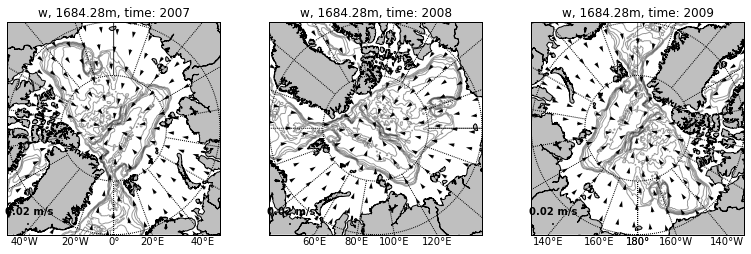

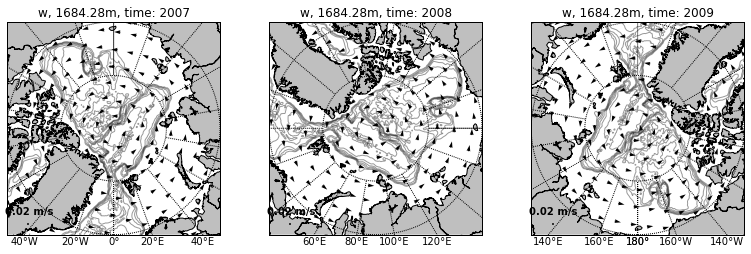

In [73]:
test(u0=0,v0=1)#all to north
test(u0=1,v0=0)#all to east

In [45]:
def velfield(lon_0):
    layer=38
    k=0
    lon=ptrc.variables['nav_lon'][:,:]
    lat=ptrc.variables['nav_lat'][:,:]
    fig = plt.figure(figsize=(18,45))
    for i in range (yearnum):
        time =i
        k+=1

        ax = fig.add_subplot(1,3,k)
        m = Basemap(projection='npstere',boundinglat=70,lon_0=lon_0,resolution='l')
        m.drawcoastlines()
        m.fillcontinents(color = '0.75')
        m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
        x_lon,y_lat = m(lon,lat)
        u =vel('U',time)
        v =vel('V',time)
        #mask too large value
        u =np.ma.masked_where(abs(v)>0.03,u)
        v =np.ma.masked_where(abs(v)>0.03,v)
        Q=m.quiver(x_lon[::20,::20], y_lat[::20,::20], u[layer,::20,::20], v[layer,::20,::20],
                   width=0.015)
        uu = np.zeros((u.shape))
        u  = u-uu

        u, v, x, y = m.rotate_vector(u[layer,:,:], v[layer,:,:], lon[:,:], lat[:,:], returnxy=True)
        Q=m.quiver(x[::20,::20], y[::20,::20], u[::20,::20], v[::20,::20],
                   width=0.015,color='red')

        Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.02, '0.02 m/s (rotated)',fontproperties={'weight': 'bold'}) #x(0-1),y(0-1), scale, label, position

        m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.4)

        plt.title('w, %sm, time: %s'%(dep[layer],2007+i))

    plt.show()

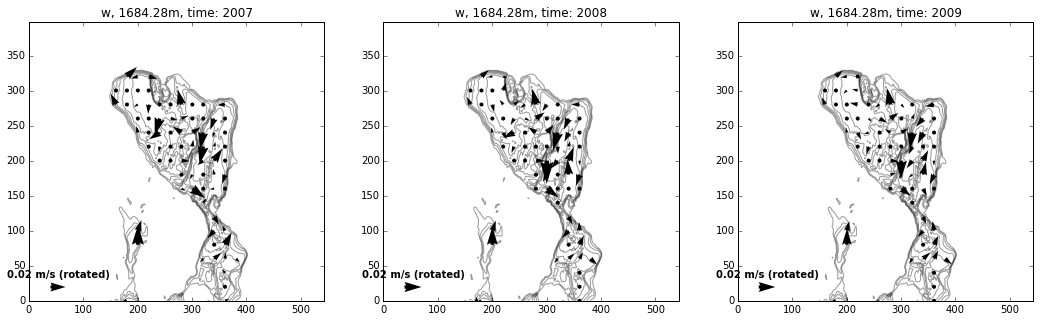

In [66]:
layer=38
k=0
lon=ptrc.variables['nav_lon'][:,:]
lat=ptrc.variables['nav_lat'][:,:]
x1d=np.linspace(0,lon[:,0].shape[0],lon[:,0].shape[0])
y1d=np.linspace(0,lon[0,:].shape[0],lon[0,:].shape[0])
x2d,y2d=np.meshgrid(y1d,x1d)

fig = plt.figure(figsize=(18,5))
for i in range (yearnum):
    time =i
    k+=1
    
    ax = fig.add_subplot(1,3,k)

    x_lon,y_lat = lon,lat
    u =vel('U',time)
    v =vel('V',time)
    #mask too large value
    u =np.ma.masked_where(abs(v)>0.03,u)
    v =np.ma.masked_where(abs(v)>0.03,v)
    Q=plt.quiver(x2d[::20,::20], y2d[::20,::20], u[layer,::20,::20], v[layer,::20,::20],
               width=0.015)
    uu = np.zeros((u.shape))
    u  = u-uu


    Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.02, '0.02 m/s (rotated)',fontproperties={'weight': 'bold'}) #x(0-1),y(0-1), scale, label, position

    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)

    plt.title('w, %sm, time: %s'%(dep[layer],2007+i))

plt.show()

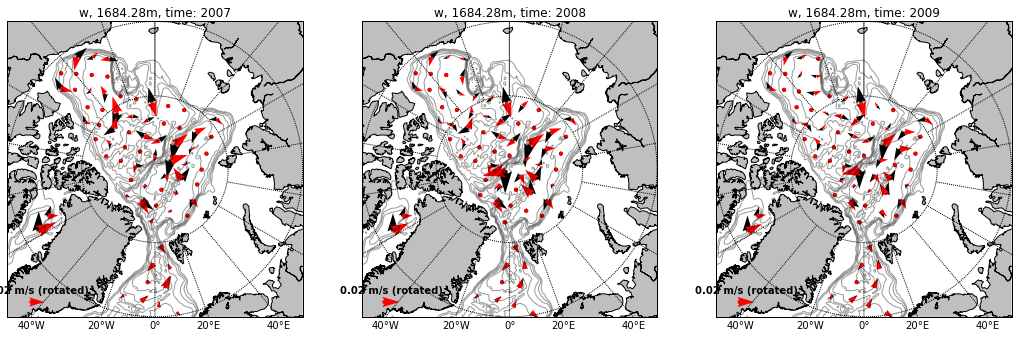

In [46]:
velfield(0)

In 2007, the arrows in CB should point to the opposite side of AR.

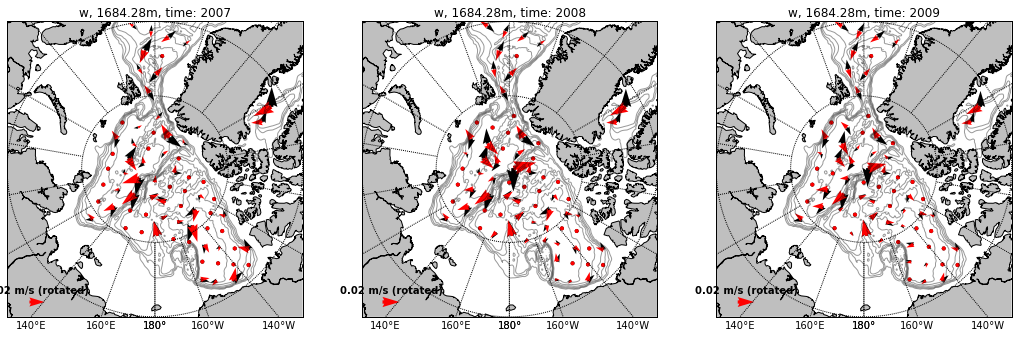

In [47]:
velfield(180)

In [55]:
#test
x1d=np.linspace(0,lon[:,0].shape[0],lon[:,0].shape[0])
y1d=np.linspace(0,lon[0,:].shape[0],lon[0,:].shape[0])
x2d,y2d=np.meshgrid(y1d,x1d)

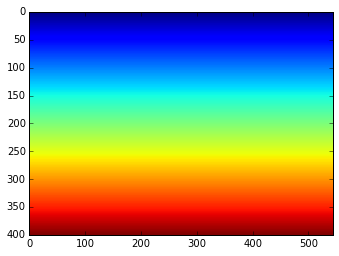

In [62]:
plt.imshow(y2d)

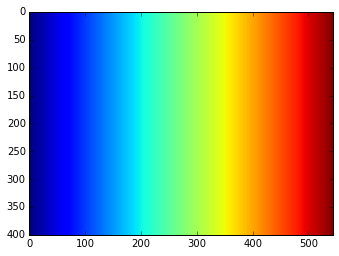

In [63]:
plt.imshow(x2d)

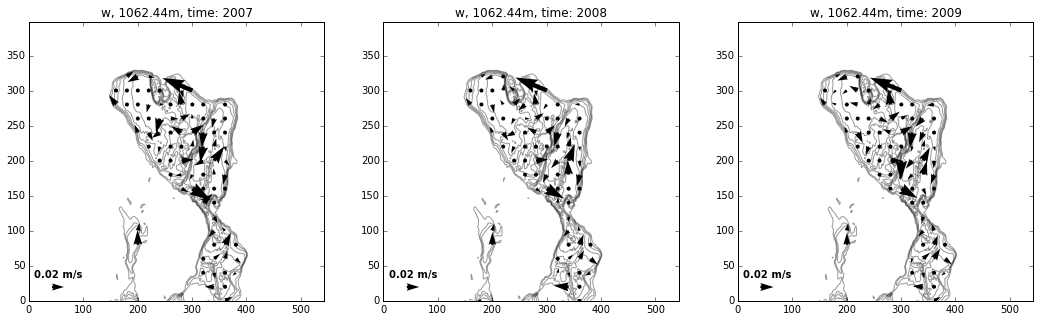

In [75]:
layer=35
k=0
lon=ptrc.variables['nav_lon'][:,:]
lat=ptrc.variables['nav_lat'][:,:]
x1d=np.linspace(0,lon[:,0].shape[0],lon[:,0].shape[0])
y1d=np.linspace(0,lon[0,:].shape[0],lon[0,:].shape[0])
x2d,y2d=np.meshgrid(y1d,x1d)

fig = plt.figure(figsize=(18,5))
for i in range (yearnum):
    time =i
    k+=1
    
    ax = fig.add_subplot(1,3,k)

    x_lon,y_lat = lon,lat
    u =vel('U',time)
    v =vel('V',time)
    #mask too large value
    u =np.ma.masked_where(abs(v)>0.03,u)
    v =np.ma.masked_where(abs(v)>0.03,v)
    Q=plt.quiver(x2d[::20,::20], y2d[::20,::20], u[layer,::20,::20], v[layer,::20,::20],
               width=0.015)
    uu = np.zeros((u.shape))
    u  = u-uu


    Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.02, '0.02 m/s',fontproperties={'weight': 'bold'}) #x(0-1),y(0-1), scale, label, position

    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)

    plt.title('w, %sm, time: %s'%(dep[layer],2007+i))

plt.show()

In [76]:
uvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridU_19692008.nc')
print uvel.variables

vvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridV_19692008.nc')
print vvel.variables

wvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridW_19692008.nc')
print wvel.variables

OrderedDict([(u'nav_lon', <netCDF4.Variable object at 0x7fa0698a8938>), (u'nav_lat', <netCDF4.Variable object at 0x7fa0698a89d0>), (u'depthu', <netCDF4.Variable object at 0x7fa0698a8d60>), (u'time_counter', <netCDF4.Variable object at 0x7fa0698a8808>), (u'vozocrtx', <netCDF4.Variable object at 0x7fa0697e93e0>), (u'sozotaux', <netCDF4.Variable object at 0x7fa0697e9478>)])
OrderedDict([(u'nav_lon', <netCDF4.Variable object at 0x7fa0697e9510>), (u'nav_lat', <netCDF4.Variable object at 0x7fa0697e9b98>), (u'depthv', <netCDF4.Variable object at 0x7fa0697e9b00>), (u'time_counter', <netCDF4.Variable object at 0x7fa0697e9050>), (u'vomecrty', <netCDF4.Variable object at 0x7fa0697e9938>), (u'sometauy', <netCDF4.Variable object at 0x7fa0697e9348>)])
OrderedDict([(u'nav_lon', <netCDF4.Variable object at 0x7fa0697e9808>), (u'nav_lat', <netCDF4.Variable object at 0x7fa0697e9f28>), (u'depthw', <netCDF4.Variable object at 0x7fa0697e9770>), (u'time_counter', <netCDF4.Variable object at 0x7fa0697e9640>),

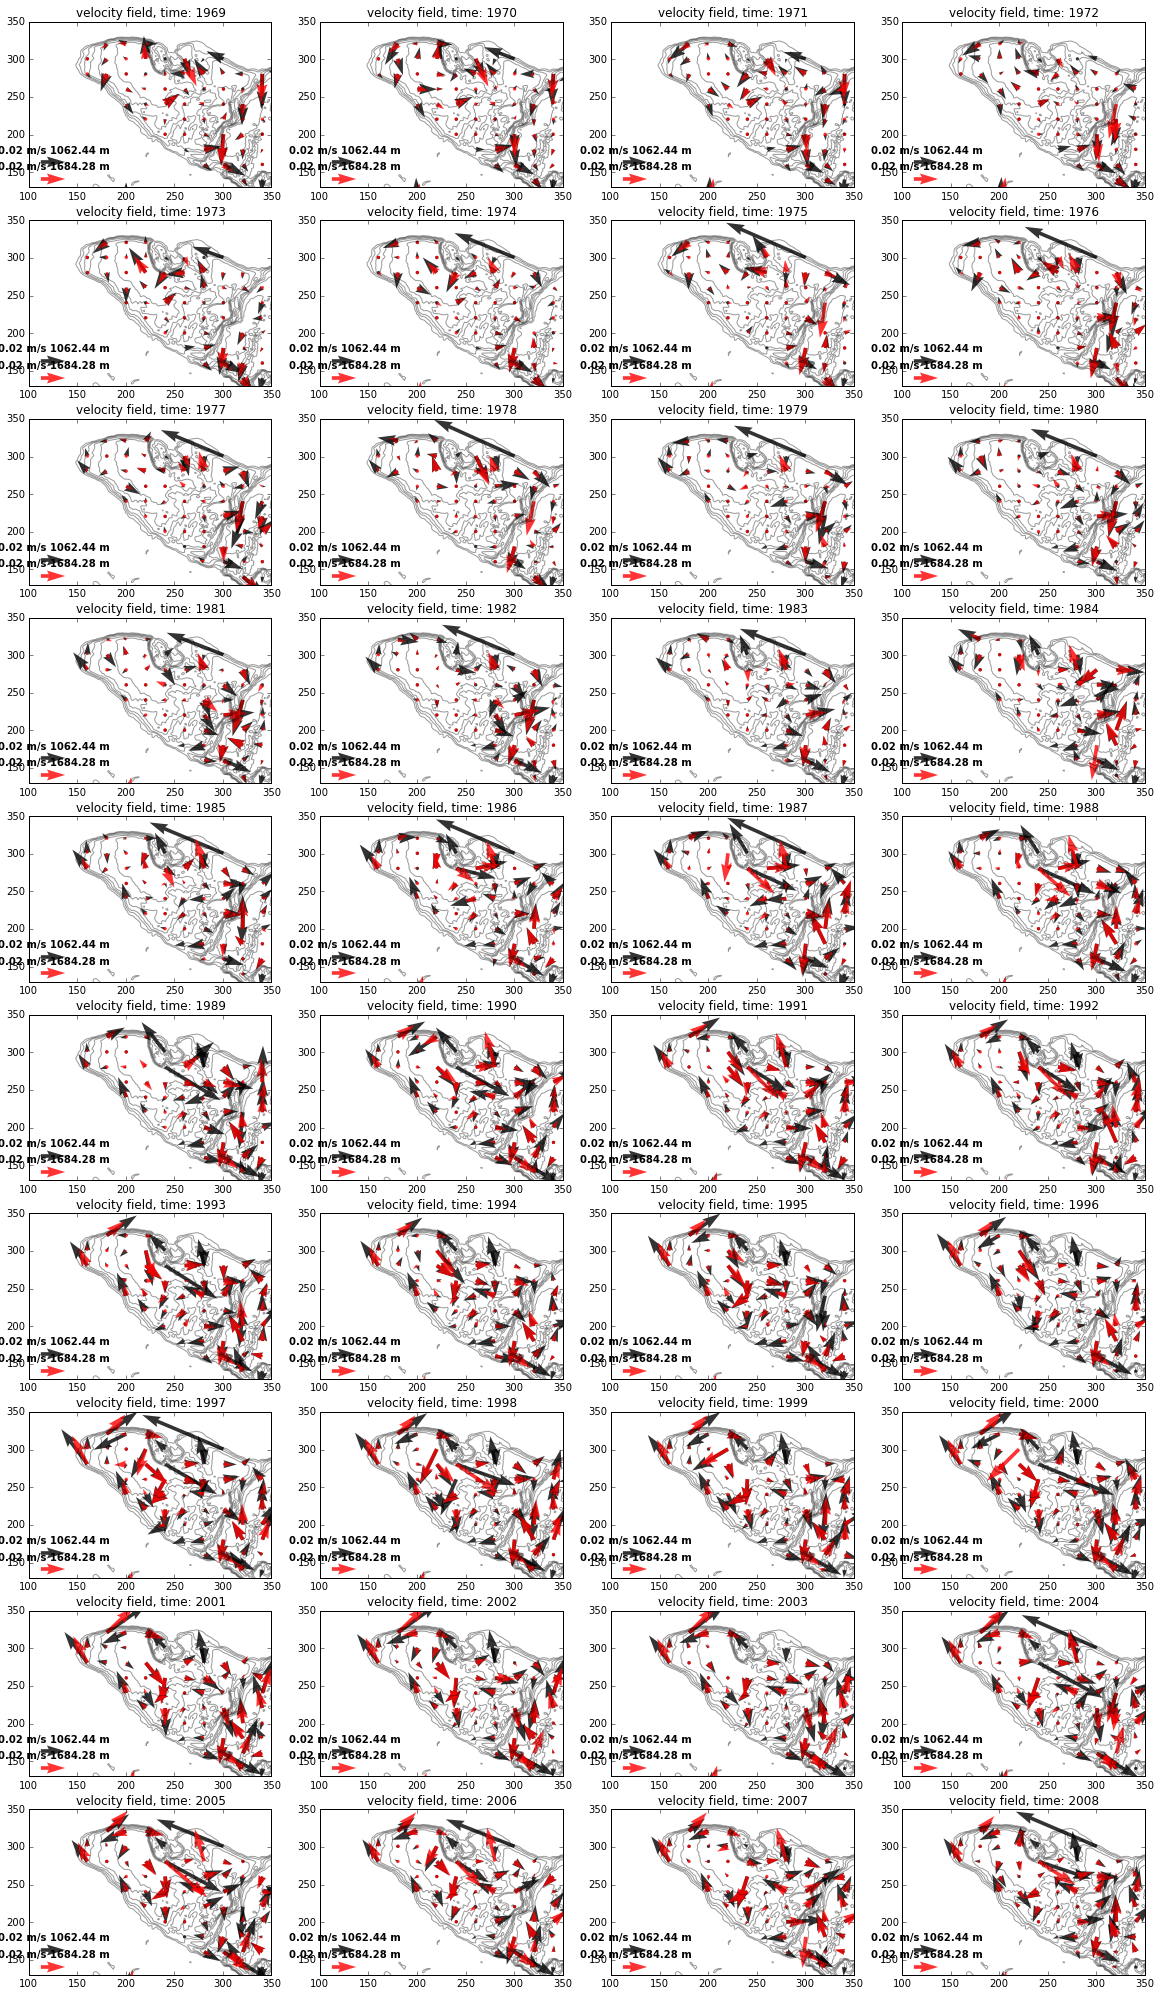

In [89]:
yearnum=40
layer=35
layer2nd=38
k=0
lon=ptrc.variables['nav_lon'][:,:]
lat=ptrc.variables['nav_lat'][:,:]
x1d=np.linspace(0,lon[:,0].shape[0],lon[:,0].shape[0])
y1d=np.linspace(0,lon[0,:].shape[0],lon[0,:].shape[0])
x2d,y2d=np.meshgrid(y1d,x1d)

fig = plt.figure(figsize=(20,35))
for i in range (yearnum):
    time =i
    k+=1
    
    ax = fig.add_subplot(10,4,k)

    x_lon,y_lat = lon,lat
    u =vel('U',time)
    v =vel('V',time)
    #mask too large value
    u =np.ma.masked_where(abs(v)>0.03,u)
    v =np.ma.masked_where(abs(v)>0.03,v)
    Q=plt.quiver(x2d[::20,::20], y2d[::20,::20], u[layer,::20,::20], v[layer,::20,::20],
               width=0.015,alpha=0.8,scale=0.2)
    Qlabel=plt.quiverkey(Q,0.1, 0.15, 0.02, '0.02 m/s %s m'%(dep[layer]),fontproperties={'weight': 'bold'}) 
    
    Q=plt.quiver(x2d[::20,::20], y2d[::20,::20], u[layer2nd,::20,::20], v[layer2nd,::20,::20],
               width=0.015,color='red',alpha=0.8,scale=0.2)
    uu = np.zeros((u.shape))
    u  = u-uu


    Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.02, '0.02 m/s %s m'%(dep[layer2nd]),fontproperties={'weight': 'bold'}) #x(0-1),y(0-1), scale, label, position

    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.ylim(130,350)    
    plt.xlim(100,350)
    plt.title('velocity field, time: %s'%(1969+i))

plt.show()

The direction of velocity in black and red looks similar. The magnitude is alike too.

* what happens to the long arrows?
* we can tell advection signal. But they are not strong. Need to weaken the effect of scavenging.
* the velocity field is tricky.. for the cb side, the positive u and v is no longer pointing to north and east.